# Section

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest   # para seleccionar atributos de forma univariada (filtros)
from sklearn.feature_selection import chi2   # estadististica para evaluar la importancia de atributos en relacion al target
from sklearn.feature_selection import RFE    # metodo recursive featute elimination
from sklearn.decomposition import PCA        # para transformacion PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # para modelos discriminantes lineales
from sklearn.naive_bayes import GaussianNB   # para modelos Naive Bayes
from sklearn.linear_model import LogisticRegression # para usar modelos de regresion logistica
from sklearn.tree import DecisionTreeClassifier     # para usar modelos de tipo arboles de decision
from sklearn.neighbors import KNeighborsClassifier  # para modelos  Knn
from sklearn.svm import SVC   # para modelos SVM

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion

from sklearn.metrics import accuracy_score, balanced_accuracy_score   # para manejar metricas de desempeño
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion
from sklearn.metrics import jaccard_score  # indice jacard


In [ ]:
def show_uniques(dataframe):
    for columna in dataframe.columns:
        print(f"Valores únicos en '{columna}': {dataframe[columna].unique()}")

In [ ]:
def handle_outliers(dataframe, columns=None, method='iqr', factor=1.5):
    if columns is None:
        columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    for col in columns:
        if method == 'iqr':
            # Calculate Q1, Q3 and IQR
            Q1 = dataframe[col].quantile(0.25)
            Q3 = dataframe[col].quantile(0.75)
            IQR = Q3 - Q1
            # Define bounds for outliers
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
        elif method == 'z-score':
            # Calculate mean and std
            mean = dataframe[col].mean()
            std = dataframe[col].std()
            # Define bounds for outliers based on z-score
            lower_bound = mean - factor * std
            upper_bound = mean + factor * std
        else:
            raise ValueError("Método no soportado. Usar 'iqr' o 'z-score'.")

        # Handle outliers - cap the outliers to the upper_bound and lower_bound
        dataframe[col] = dataframe[col].clip(lower=lower_bound, upper=upper_bound)

        # Contar los outliers (opcional, podría omitirse si el reemplazo es suficiente)
        n_outliers = ((dataframe[col] == lower_bound) | (dataframe[col] == upper_bound)).sum()
        print(f'Columna {col}:')
        print(f'Se considera atípicos a los valores mayores al límite superior: {upper_bound:.12}')
        print(f'Se considera atípicos a los valores menores al límite inferior: {lower_bound:.12}')
        print(f'Ello incluye un total de {n_outliers} registros ({n_outliers/len(dataframe[col]):.4%})\n')

    return dataframe

In [ ]:
def make_boxplot(dataframe):
    # Número de columnas numéricas
    num_columns = dataframe.select_dtypes(include=['float64', 'int64']).shape[1]

    # Configura el tamaño de la figura para acomodar todos los subplots
    plt.figure(figsize=(5 * num_columns, 4))

    # Itera sobre las columnas numéricas para crear un boxplot para cada una
    for i, column in enumerate(dataframe.select_dtypes(include=['float64', 'int64']).columns):
        plt.subplot(1, num_columns, i + 1)  # (1, num_columns, index)
        dataframe[column].plot(kind='box', grid=True)
        plt.title(column)

    plt.show()

In [ ]:
def encode_categorical_column(dataframe, columns=None, encoding_type='LabelEncoder'):
    """
    Encodes a categorical column in the dataframe to numeric format using the specified encoding type.
    """
    if columns is None:
        columns = dataframe.select_dtypes(include=['object', 'category']).columns

    if encoding_type not in ['get_dummies', 'LabelEncoder', 'OneHotEncoder']:
        raise ValueError("encoding_type must be 'get_dummies', 'LabelEncoder', or 'OneHotEncoder'")

    for column in columns:

        if encoding_type == 'get_dummies':
            # Use pandas get_dummies for one-hot encoding
            dummies = pd.get_dummies(dataframe[column])
            dataframe = pd.concat([dataframe.drop(column, axis=1), dummies], axis=1)
        elif encoding_type == 'LabelEncoder':
            # Use LabelEncoder for label encoding
            le = LabelEncoder()
            dataframe[column] = le.fit_transform(dataframe[column])
        elif encoding_type == 'OneHotEncoder':
            # Use OneHotEncoder from scikit-learn for one-hot encoding
            df.reset_index(inplace=True)
            ohe = OneHotEncoder(sparse_output=False)
            encoded_features = ohe.fit_transform(dataframe[[column]])
            encoded_feature_names = ohe.get_feature_names_out(input_features=[column])
            dataframe = pd.concat([dataframe.drop(column, axis=1), pd.DataFrame(encoded_features, columns=encoded_feature_names)], axis=1)

    return dataframe

In [ ]:
def show_bar_plots(dataframe, columns=None):
    if columns is None:
        columns = dataframe.select_dtypes(include=['object']).columns
    for col in columns:
        # Obtener las frecuencias de la columna actual
        value_counts = dataframe[col].value_counts()
        # Si hay más de 25 categorías, agrupar las menos comunes en 'Others'
        if len(value_counts) > 25:
            top_categories = value_counts.iloc[:25]
            others_sum = value_counts.iloc[25:].sum()
            new_value_counts = top_categories.append(pd.Series(others_sum, index=['Others']))
        else:
            new_value_counts = value_counts

        # Graficar el gráfico de barras
        plt.figure(figsize=(10, 8))  # Ajustar el tamaño antes de la visualización
        sns.barplot(y=new_value_counts.index, x=new_value_counts.values)
        plt.xlabel('Frecuencia')
        plt.ylabel('Categoría')
        plt.title(f'Distribución de la categoría - {col}')
        plt.show()

In [ ]:
def show_correlation_matrix(dataframe,method='pearson'):
    # Configurar el tamaño de la figura
    plt.figure(figsize=(10, 8))

    # Crear un heatmap para visualizar la matriz de correlación
    sns.heatmap(dataframe.corr(numeric_only = True, method=method), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .5})

    # Mostrar el gráfico
    plt.show()

In [ ]:
def see_histogram(dataframe, columns=None):
    if columns==None:
        columns = dataframe.columns
    for column in columns:
        # Verificar si la columna es numérica
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            plt.figure(figsize=(10, 6))
            sns.histplot(dataframe[column], kde=True, color='skyblue')
            plt.title(f'Histogram for {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.show()
            skewness = dataframe[column].skew()
            print(f'Skewness of {column}: {skewness}\n')
        else:
            # Verificar si la columna categórica está codificada adecuadamente
            unique_values = dataframe[column].unique()
            if all(isinstance(value, int) or isinstance(value, float) for value in unique_values):
                plt.figure(figsize=(10, 6))
                sns.countplot(x=column, data=dataframe)
                plt.title(f'Count plot for {column}')
                plt.xlabel(column)
                plt.ylabel('Count')
                plt.show()

            else:
                print(f'La columna "{column}" es categórica y falta codificar esa clase.')

PRE PROCESAMIENTO

In [ ]:
# Lectura del dataset
df = pd.read_csv('Application_Data.csv')
print('Se leyo un dataset de dimensiones {}'.format(df.shape))
df.head()

Se leyo un dataset de dimensiones (25128, 21)


,Applicant_ID,Applicant_Gender,Owned_Car,Owned_Realty,Total_Children,Total_Income,Income_Type,Education_Type,Family_Status,Housing_Type,...,Owned_Work_Phone,Owned_Phone,Owned_Email,Job_Title,Total_Family_Members,Applicant_Age,Years_of_Working,Total_Bad_Debt,Total_Good_Debt,Status
0,5008806,M,1,1,0,112500,Working ...,Secondary / secondary special ...,Married ...,House / apartment ...,...,0,0,0,Security staff ...,2,59,4,0,30,1
1,5008808,F,0,1,0,270000,Commercial associate ...,Secondary / secondary special ...,Single / not married ...,House / apartment ...,...,0,1,1,Sales staff ...,1,53,9,0,5,1
2,5008809,F,0,1,0,270000,Commercial associate ...,Secondary / secondary special ...,Single / not married ...,House / apartment ...,...,0,1,1,Sales staff ...,1,53,9,0,5,1
3,5008810,F,0,1,0,270000,Commercial associate ...,Secondary / secondary special ...,Single / not married ...,House / apartment ...,...,0,1,1,Sales staff ...,1,53,9,0,27,1
4,5008811,F,0,1,0,270000,Commercial associate ...,Secondary / secondary special ...,Single / not married ...,House / apartment ...,...,0,1,1,Sales staff ...,1,53,9,0,39,1


In [ ]:
# muestra la distribucion de las clases
print(df.groupby('Status').size())
#observamos que es un problema de clases desbalanceadas

Status
0      121
1    25007
dtype: int64


In [ ]:
# Nulos
df.isna().sum() / len(df)

,0
Applicant_ID,0.0
Applicant_Gender,0.0
Owned_Car,0.0
Owned_Realty,0.0
Total_Children,0.0
Total_Income,0.0
Income_Type,0.0
Education_Type,0.0
Family_Status,0.0
Housing_Type,0.0


In [ ]:
df.dtypes

,0
Applicant_ID,int64
Applicant_Gender,object
Owned_Car,int64
Owned_Realty,int64
Total_Children,int64
Total_Income,int64
Income_Type,object
Education_Type,object
Family_Status,object
Housing_Type,object


In [ ]:
df = df.drop(columns = ['Applicant_ID'])

In [ ]:
#Revisión de únicos
df.nunique()

,0
Applicant_Gender,2
Owned_Car,2
Owned_Realty,2
Total_Children,6
Total_Income,195
Income_Type,5
Education_Type,5
Family_Status,5
Housing_Type,6
Owned_Mobile_Phone,1


In [ ]:
df = df.drop(columns = ['Owned_Mobile_Phone'])

In [ ]:
df.nunique() / len(df)

,0
Applicant_Gender,0.000080
Owned_Car,0.000080
Owned_Realty,0.000080
Total_Children,0.000239
Total_Income,0.007760
Income_Type,0.000199
Education_Type,0.000199
Family_Status,0.000199
Housing_Type,0.000239
Owned_Work_Phone,0.000080


In [ ]:
show_uniques(df)

Valores únicos en 'Applicant_Gender': ['M      ' 'F      ']
Valores únicos en 'Owned_Car': [1 0]
Valores únicos en 'Owned_Realty': [1 0]
Valores únicos en 'Total_Children': [0 3 1 2 4 5]
Valores únicos en 'Total_Income': [ 112500  270000  135000  130500  157500  405000  211500  360000  126000
  247500  297000  166500  225000  315000  148500  202500  450000  180000
   90000  765000  229500  292500   74250  144000  337500  193500  267750
  139500   67500  252000  900000  279000   76500  234000   81000  108000
  198000  216000   45000  238500  117000 1350000   99000  445500  427500
  306000  328500  310500  540000  171000  675000  121500   72000  184500
  189000  243000   94500  256500  697500  196650   40500  432000  162000
  103500  257625   58500  207000  720000  261000  175500  382500  119250
   63000  274500   90900  495000  220500   49500  630000  585000  145350
  173250  531000  387000 1125000  283500   36000  179100  265500  118350
  123750  116654  153000  324000  351000  441000 

In [ ]:
# En el caso de las columnas con pocas variables, se puede label encoder

label_encoder = LabelEncoder().fit(df['Income_Type'])
df['Income_Type'] = label_encoder.transform(df['Income_Type'])

label_encoder = LabelEncoder().fit(df['Education_Type'])
df['Education_Type'] = label_encoder.transform(df['Education_Type'])

label_encoder = LabelEncoder().fit(df['Family_Status'])
df['Family_Status'] = label_encoder.transform(df['Family_Status'])

label_encoder = LabelEncoder().fit(df['Housing_Type'])
df['Housing_Type'] = label_encoder.transform(df['Housing_Type'])

label_encoder = LabelEncoder().fit(df['Job_Title'])
df['Job_Title'] = label_encoder.transform(df['Job_Title'])

# Para los que solo tienen dos clases, podemos binarizarlas

df['Applicant_Gender'] = df['Applicant_Gender'].map({'M      ': 1, 'F      ': 0})

In [ ]:
df.head()

,Applicant_Gender,Owned_Car,Owned_Realty,Total_Children,Total_Income,Income_Type,Education_Type,Family_Status,Housing_Type,Owned_Work_Phone,Owned_Phone,Owned_Email,Job_Title,Total_Family_Members,Applicant_Age,Years_of_Working,Total_Bad_Debt,Total_Good_Debt,Status
0,1,1,1,0,112500,4,4,1,1,0,0,0,16,2,59,4,0,30,1
1,0,0,1,0,270000,0,4,3,1,0,1,1,14,1,53,9,0,5,1
2,0,0,1,0,270000,0,4,3,1,0,1,1,14,1,53,9,0,5,1
3,0,0,1,0,270000,0,4,3,1,0,1,1,14,1,53,9,0,27,1
4,0,0,1,0,270000,0,4,3,1,0,1,1,14,1,53,9,0,39,1


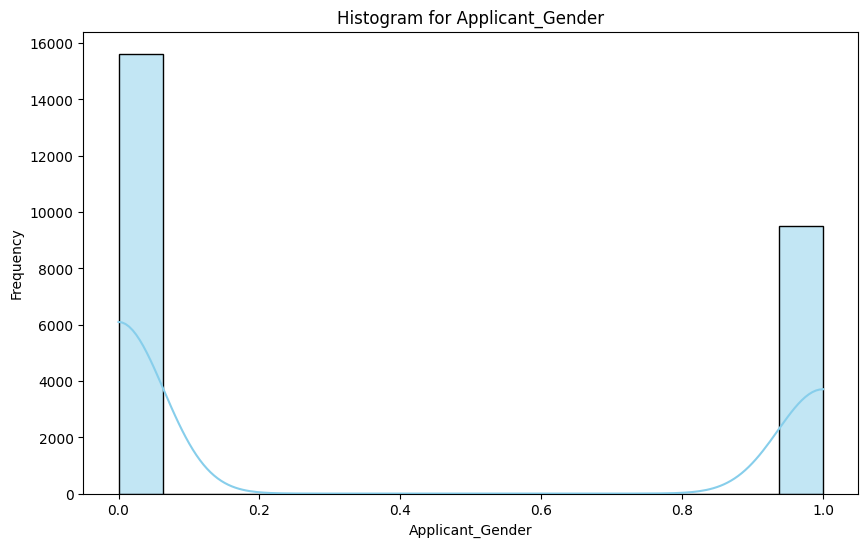

Skewness of Applicant_Gender: 0.5027828477659744



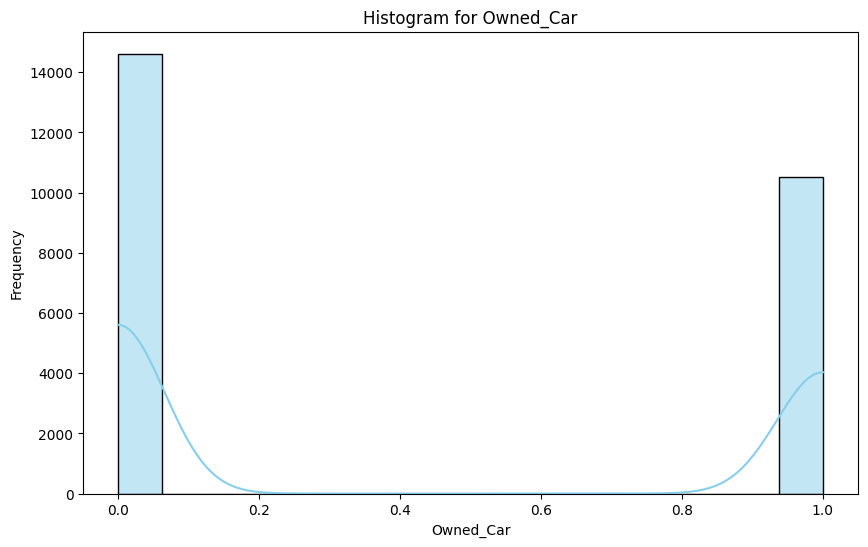

Skewness of Owned_Car: 0.3309472983422363



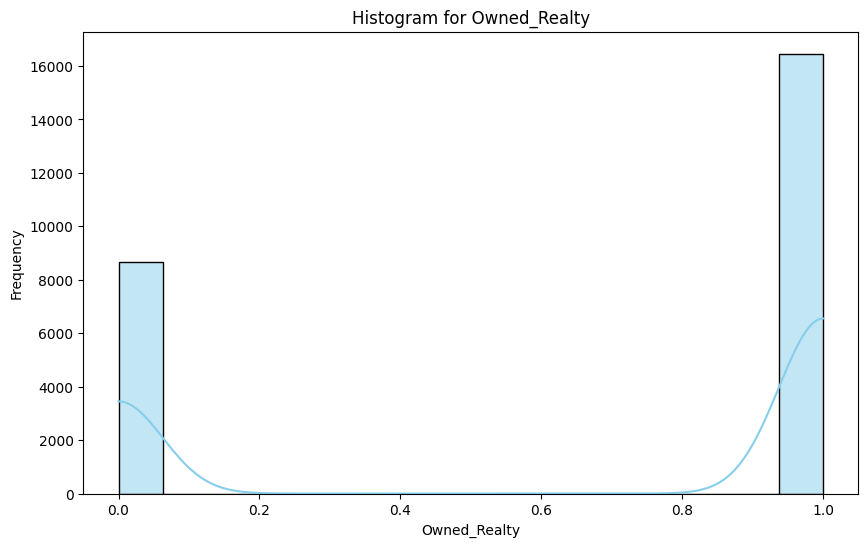

Skewness of Owned_Realty: -0.6518240762415578



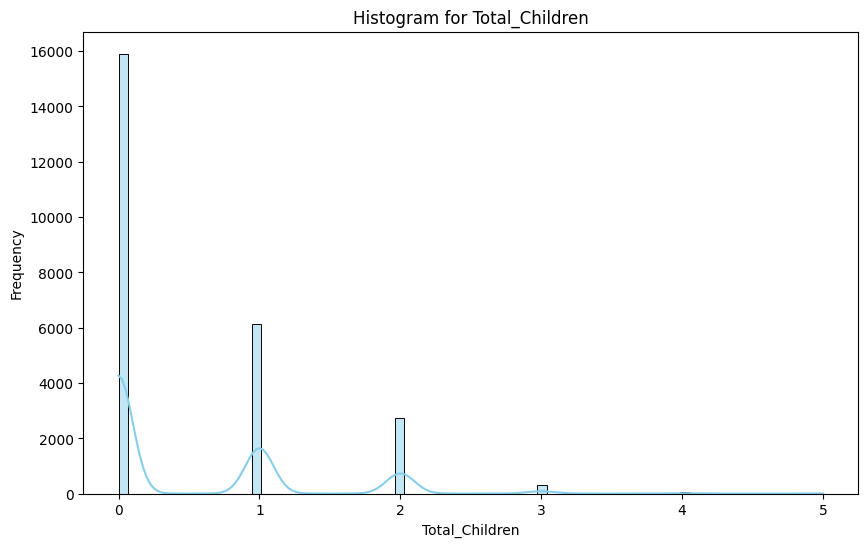

Skewness of Total_Children: 1.4772750155469205



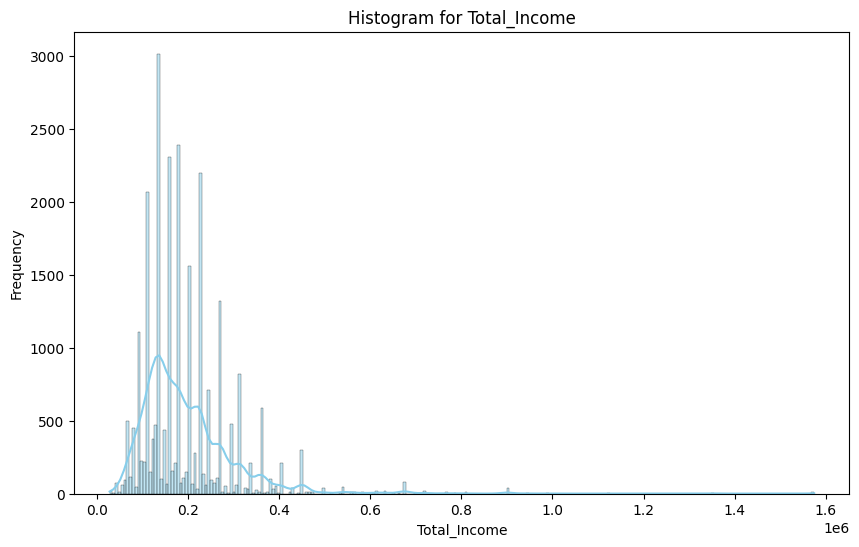

Skewness of Total_Income: 2.964037810898012



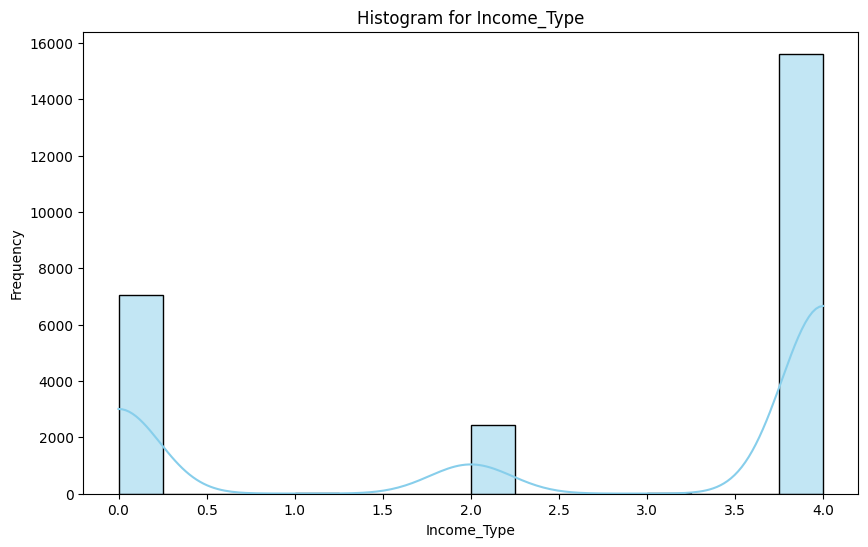

Skewness of Income_Type: -0.7208403139934253



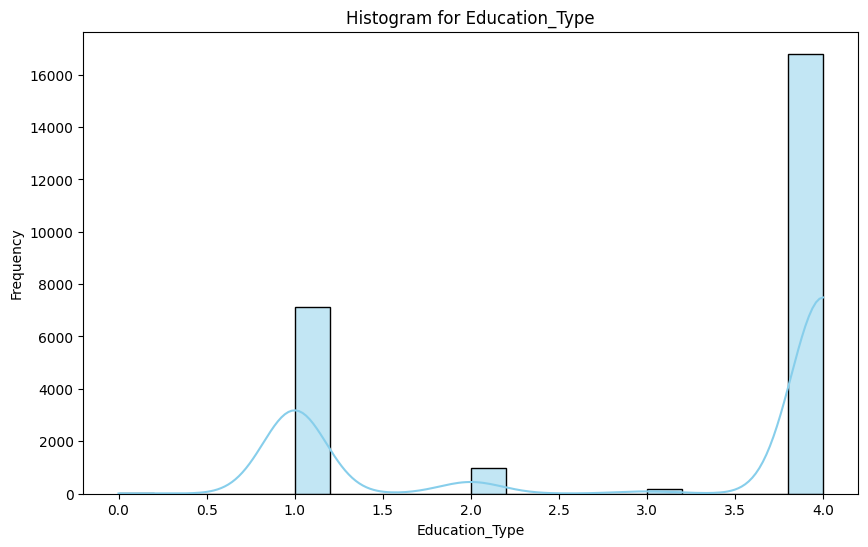

Skewness of Education_Type: -0.7932866971857482



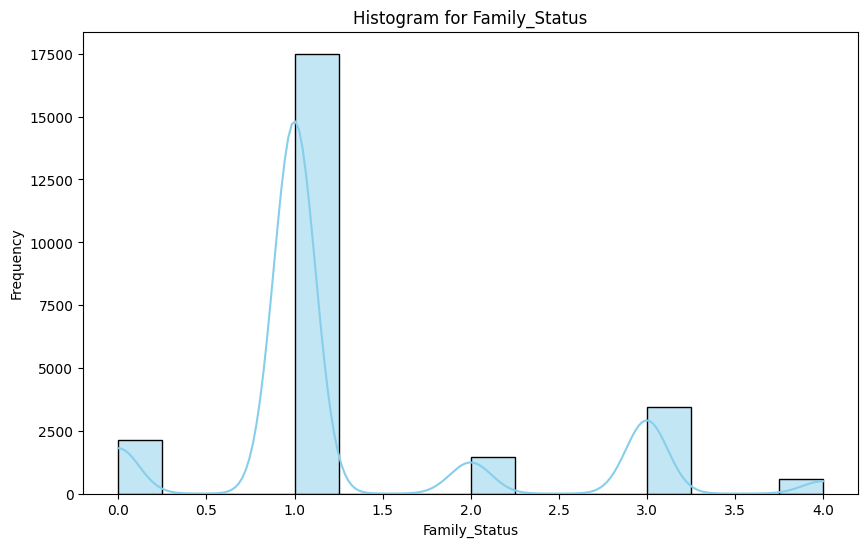

Skewness of Family_Status: 1.2638663478921266



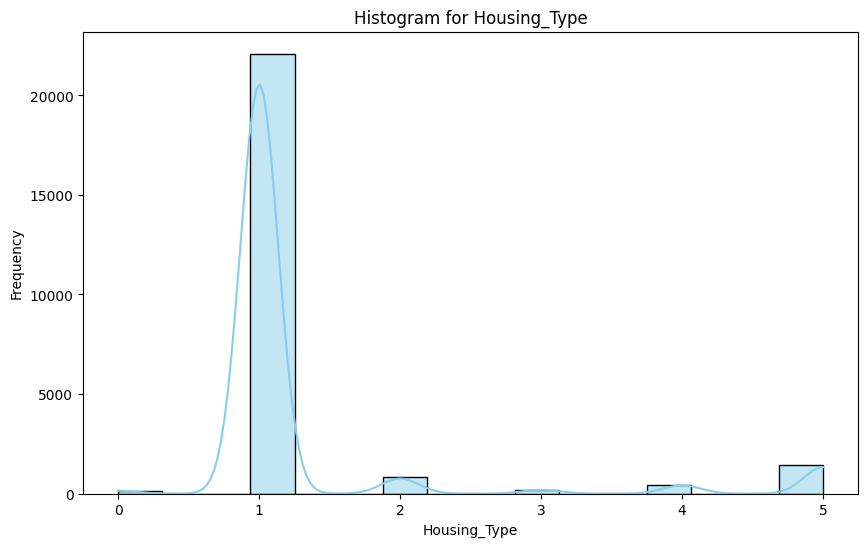

Skewness of Housing_Type: 3.0156398002284344



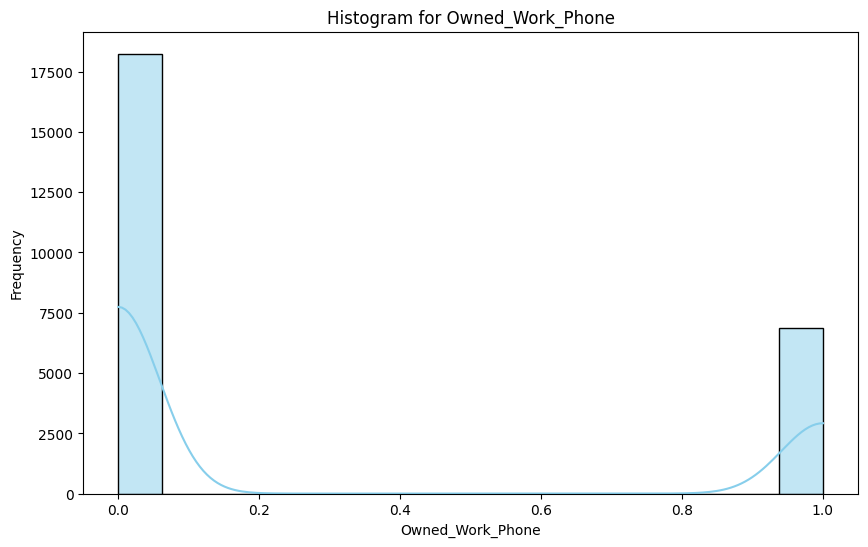

Skewness of Owned_Work_Phone: 1.0148554784818



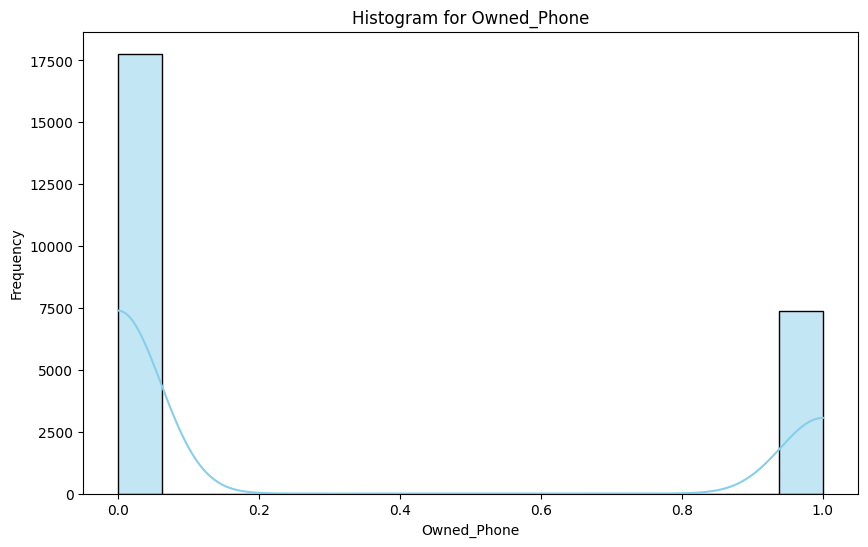

Skewness of Owned_Phone: 0.91104092159702



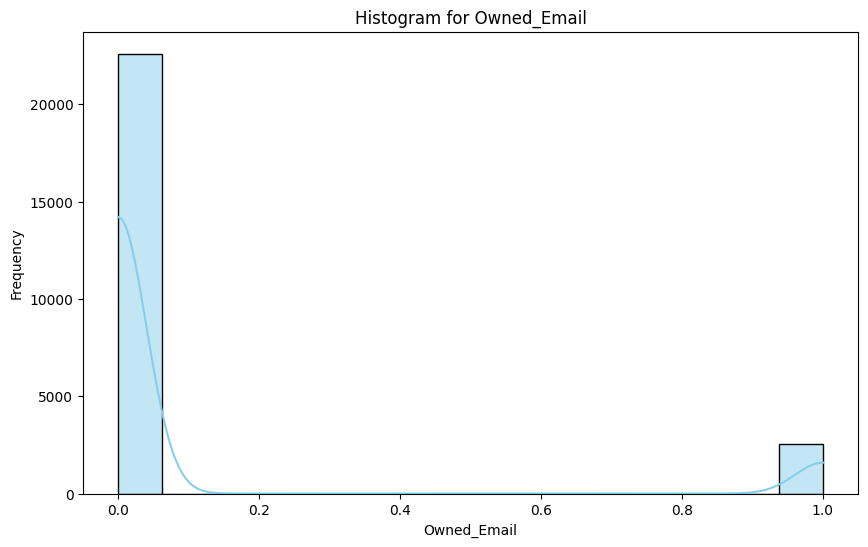

Skewness of Owned_Email: 2.6542067893840953



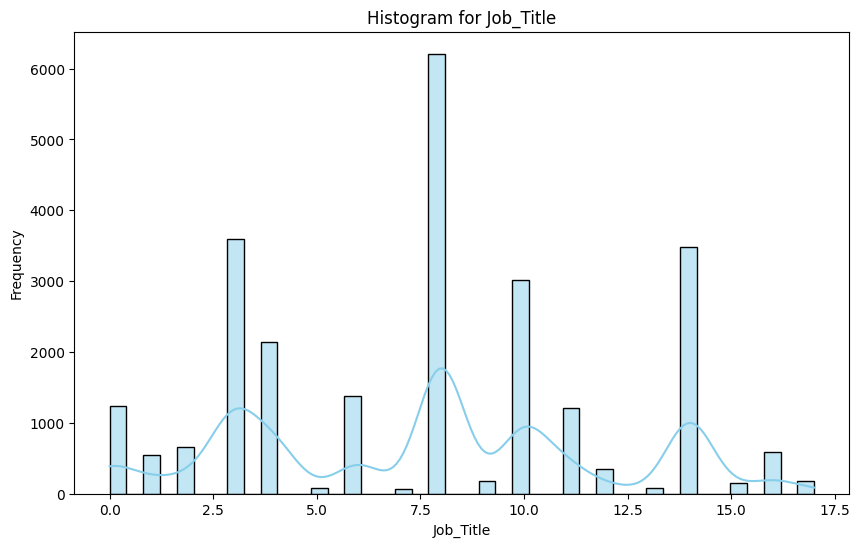

Skewness of Job_Title: 0.08699523968338947



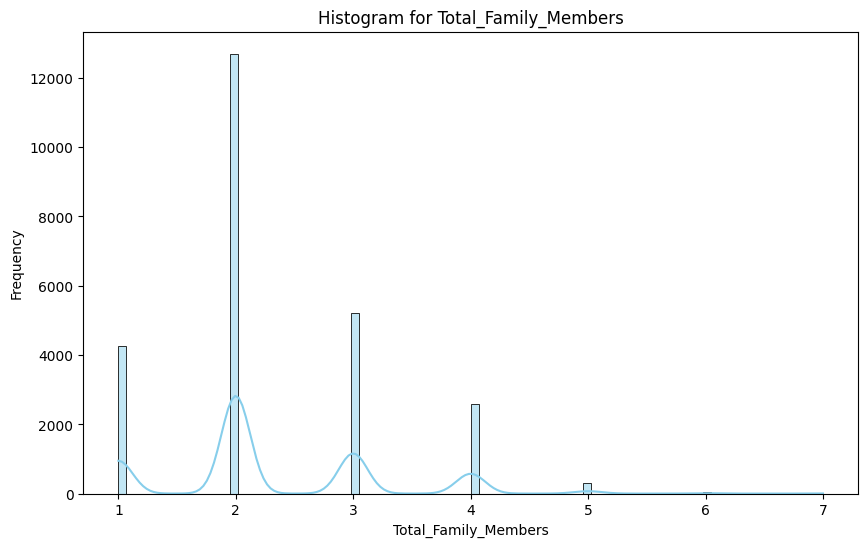

Skewness of Total_Family_Members: 0.7844887442337911



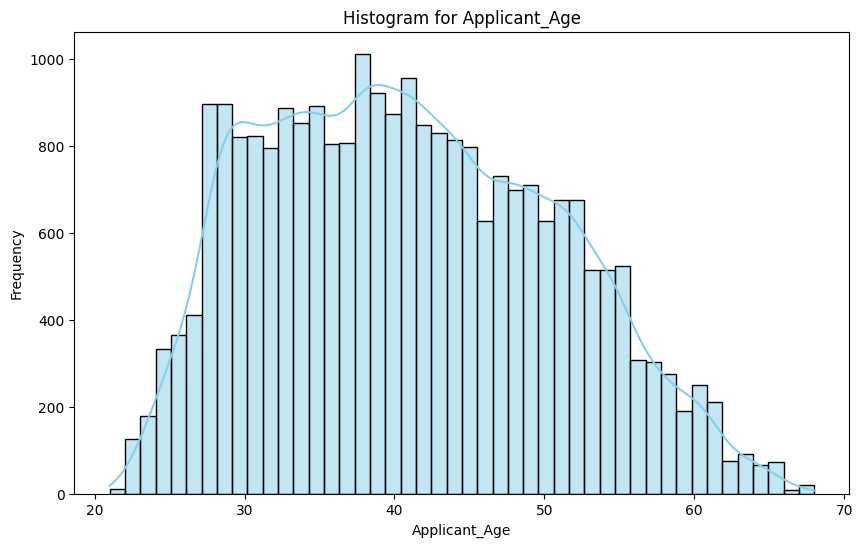

Skewness of Applicant_Age: 0.27145447040373916



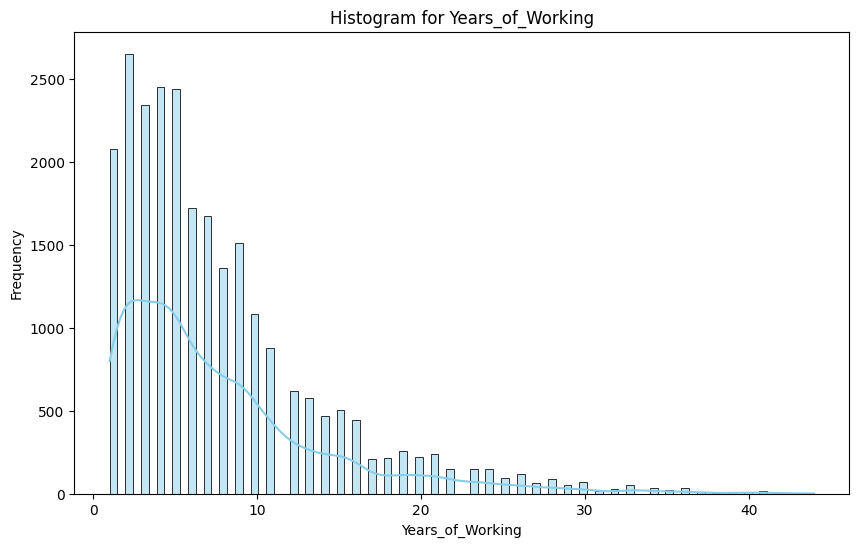

Skewness of Years_of_Working: 1.7242349362023368



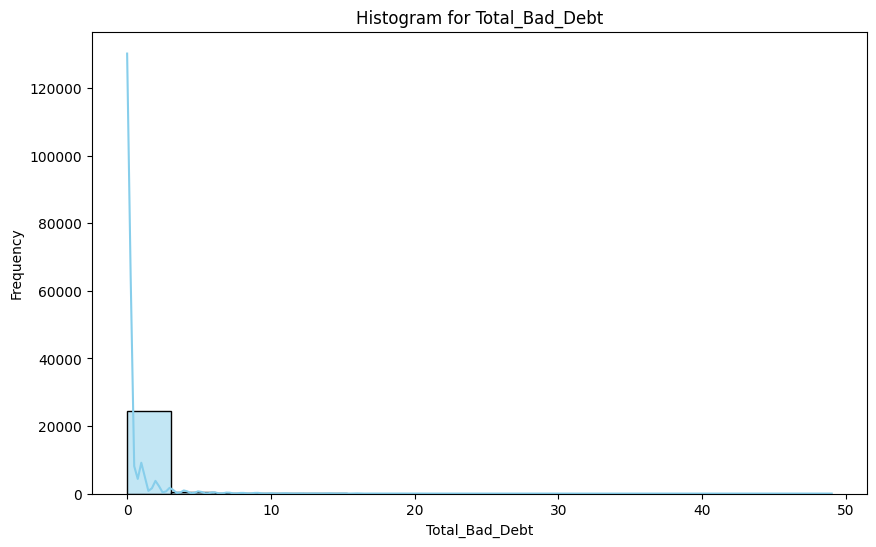

Skewness of Total_Bad_Debt: 12.432799215282186



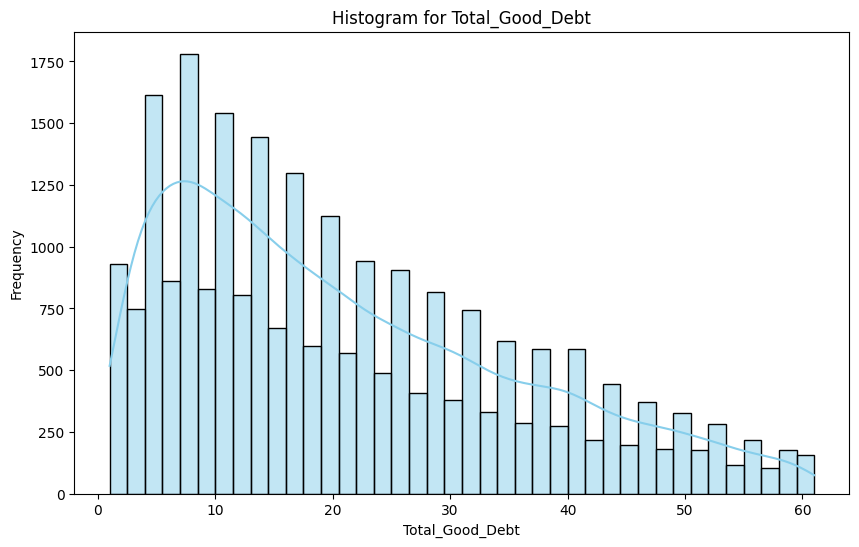

Skewness of Total_Good_Debt: 0.7382906800171972



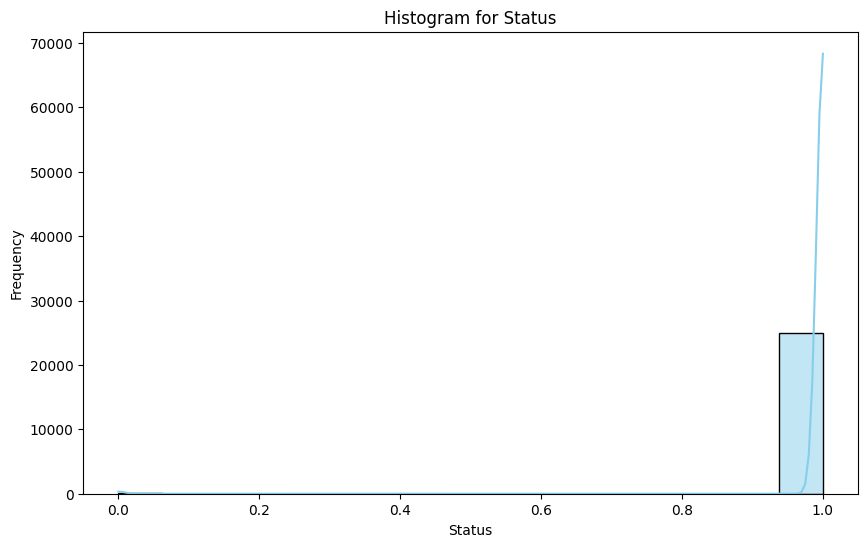

Skewness of Status: -14.307295290381374



In [ ]:
see_histogram(df)

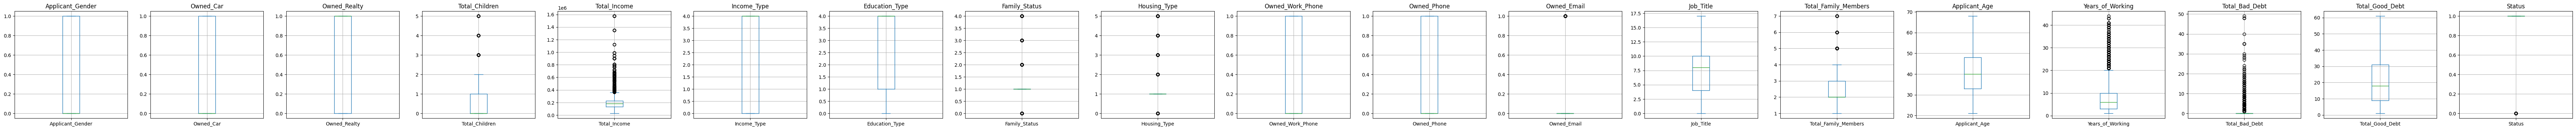

In [ ]:
make_boxplot(df)

In [ ]:
# tratamiento de valores atipicos

def corrige_outliers(dfx, columnas_lst):
  for columna in columnas_lst:
    q1 = dfx[columna].quantile(0.25)
    q3 = dfx[columna].quantile(0.75)
    iqr = q3 - q1
    ul = q3 + 1.5*iqr
    ll = q1 - 1.5*iqr
    dfx.loc[dfx[columna]>ul, columna] = ul
    dfx.loc[dfx[columna]<ll, columna] = ll
  return dfx

columnas_lst = ['Total_Children', 'Total_Income', 'Years_of_Working']

df = corrige_outliers(df, columnas_lst)

<ipython-input-65-1f12083a33d8>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfx.loc[dfx[columna]>ul, columna] = ul
<ipython-input-65-1f12083a33d8>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfx.loc[dfx[columna]>ul, columna] = ul


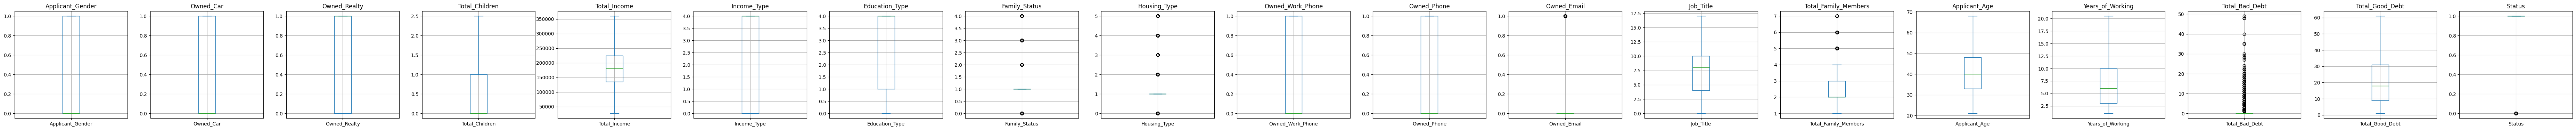

In [ ]:
make_boxplot(df)

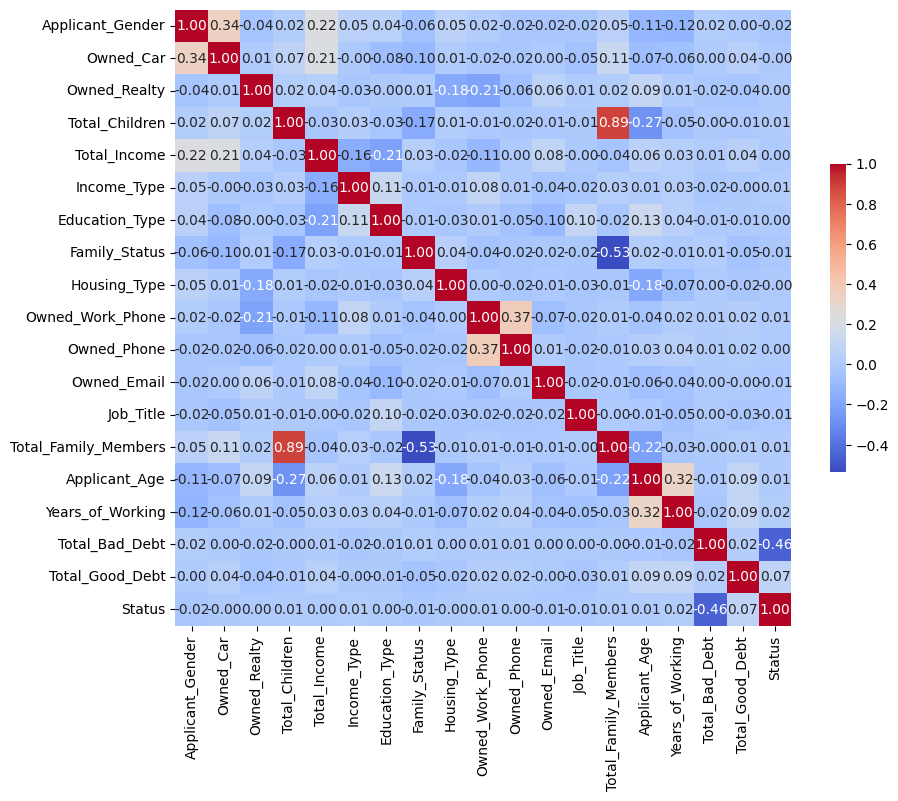

In [ ]:
show_correlation_matrix(df)

In [ ]:
#el numero de miembros en la familia y el total de hijos son atributos redundantes, solo necesitamos uno
df = df.drop(columns = ['Total_Children'])

TRAIN - PRUEBA

In [ ]:
array = df.values
X = array[:,0:17]  # atributos
y = array[:,17]    # target

# realiza el train-test split
test_size = 0.25    # proporcion de muestras para validacion
seed = 42   # semilla para el generador aleatorio (para reproductibilidad)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

print('Training: %d ejemplos. Test: %d ejemplos' % (len(y_train), len(y_test)))

Training: 18846 ejemplos. Test: 6282 ejemplos


In [ ]:
# Definimos el pool de algoritmos de ML a evaluar
algos = []
algos.append(('LogReg', LogisticRegression(solver='liblinear'))) # Lgistic regresors con solver liblinear
algos.append(('5NN', KNeighborsClassifier(n_neighbors=5))) # KNN con 5 vecinos
algos.append(('10NN', KNeighborsClassifier(n_neighbors=10))) # KNN con 10 vecinos
algos.append(('DT_20', DecisionTreeClassifier(max_depth=20))) # DecisionTree gini con profundidad 20
algos.append(('DT_40', DecisionTreeClassifier(max_depth=20))) # DecisionTree gini con profundidad 40
algos.append(('DT', DecisionTreeClassifier(max_depth=None))) # DecisionTree gini sin restricción de profundidad

In [ ]:
# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 42
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

#  evalua cada algoritmo de ML
for algoname, algo in algos:
    cv_results = cross_val_score(algo, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))

LogReg: 0.5994967532467532 (0.05548616994564476)
5NN: 0.5475811688311689 (0.054190269139748254)
10NN: 0.5296428571428571 (0.04684020817674507)
DT_20: 0.9577739065738863 (0.030760255153104907)
DT_40: 0.9699167637167434 (0.03256110580985952)
DT: 0.9627738357273896 (0.03306755625792455)


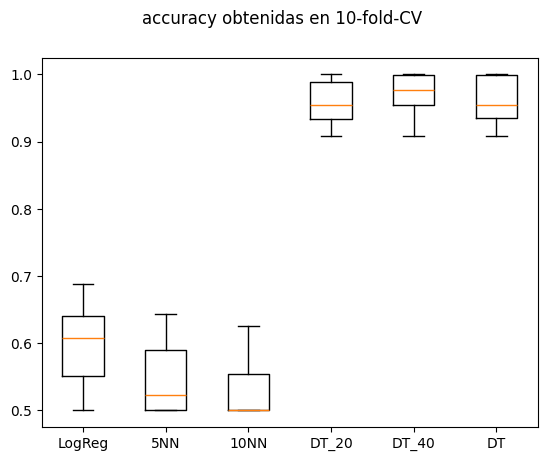

In [ ]:
# Muestra graficamente los resultados de accuracy en crossvalidacion de los Algoritmos evaluados
fig = plt.figure()
fig.suptitle('accuracy obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Accuracy score: 0.9995224450811844

Matriz de Confusión:
[[  32    2]
 [   1 6247]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96        34
         1.0       1.00      1.00      1.00      6248

    accuracy                           1.00      6282
   macro avg       0.98      0.97      0.98      6282
weighted avg       1.00      1.00      1.00      6282



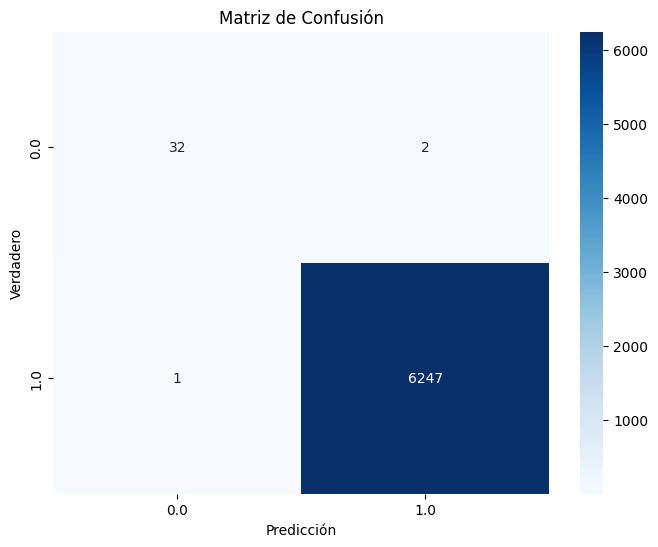

In [ ]:
model = DecisionTreeClassifier(max_depth=None)
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_test, y_predicted))

conf_matrix = confusion_matrix(y_test, y_predicted)
# Mostrar la matriz de confusión como imagen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()